# Data Extraction

As the data size is large and I have limited resources I will not load all the shards at once. We first use one shard to explore the data and doing analysis on it.

## Importing Requirements

In [ ]:
!pip install git+http://hf.co/usm3d/tools.git

In [ ]:
import webdataset as wds
import numpy as np
from huggingface_hub import hf_hub_download
from hoho import proc
from tqdm import tqdm
import sys
sys.path.append('..')

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:
from pprint import pprint


import matplotlib.pyplot as plt

import numpy as np
import scipy.cluster.hierarchy as shc
import scipy.interpolate as si
import pycolmap as pc

import hoho
hoho.LOCAL_DATADIR = hoho.setup("../data")
from hoho import compute_WED
from hoho import vis
from hoho.vis import line

from scipy.spatial.distance import cdist
import cv2

from tqdm import tqdm
import trimesh


from sklearn.cluster import DBSCAN

Using ../data as the data directory (we are running locally)


In [ ]:
import datasets

In [ ]:
from datasets import Features, Sequence, Value, Array2D, Image

In [ ]:
split = "all"
samples = []
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    if i > 10:
        break
    samples.append((hoho.decode(sample)))


/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning:

streaming isn't using with 'all': changing `split` to 'train'

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning:

no tarfiles found in ../data.

11it [00:08,  1.37it/s]


In [ ]:
#useless I guess


# Define the namedtuples

# Define the features dictionary
features = Features({
    "order_id": Value(dtype="string"),

    # inputs
    "K": Sequence(Array2D(dtype="float32", shape=(3, 3))),
    "R": Sequence(Array2D(dtype="float32", shape=(3, 3))),
    "t": Sequence(Sequence(Value(dtype="float32"), length=3)),  # in centimeters
    "gestalt": Sequence(Image()),
    "ade20k": Sequence(Image()),
    "depthcm": Sequence(Image()),  # in centimeters

    # result of Colmap reconstruction loaded in named tuples
    # More on format: https://github.com/colmap/colmap/blob/main/scripts/python/read_write_model.py#L47
    "images": Sequence({
        "id": Value(dtype="int32"),
        "qvec": Sequence(Value(dtype="float32")),
        "tvec": Sequence(Value(dtype="float32")),
        "camera_id": Value(dtype="int32"),
        "name": Value(dtype="string"),
        "xys": Sequence(Sequence(Value(dtype="float32"))),
        "point3D_ids": Sequence(Value(dtype="int64"))
    }),
    "points3d": Sequence({
        "id": Value(dtype="int32"),
        "xyz": Sequence(Value(dtype="float32")),
        "rgb": Sequence(Value(dtype="int32")),
        "error": Value(dtype="float32"),
        "image_ids": Sequence(Value(dtype="int32")),
        "point2D_idxs": Sequence(Value(dtype="int32"))
    }),
    "cameras": Sequence({
        "id": Value(dtype="int32"),
        "model": Value(dtype="string"),
        "width": Value(dtype="int32"),
        "height": Value(dtype="int32"),
        "params": Sequence(Value(dtype="float32"))
    }),

    # side info during training
    "mesh_vertices": Sequence(Sequence(Value(dtype="float32"), length=3)),
    "mesh_faces": Sequence(Sequence(Value(dtype="int64"))),
    "face_semantics": Sequence(Value(dtype='int64')),
    "edge_semantics": Sequence(Value(dtype='int64')),

    # targets
    "wf_vertices": Sequence(Sequence(Value(dtype="float32"), length=3)),  # in centimeters
    "wf_edges": Sequence(Sequence(Value(dtype="int64"), length=2)),
})


In [ ]:
split = "all"
next(iter(hoho.get_dataset(split=split)))

{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'PIL.Image.Image'>], 'depthcm': [<class 'PIL.Image.Image'>], 'gestalt': [<class 'PIL.Image.Image'>], 'wf_vertices': (30, 3), 'wf_edges': (32, 2), 'edge_semantics': (32,), 'mesh_vertices': (380, 3), 'mesh_faces': (236, 4), 'face_semantics': (236,), 'K': (3, 3, 3), 'R': (3, 3, 3), 't': (3, 3), 'images': <class 'bytes'>, 'points3d': <class 'bytes'>, 'cameras': <class 'bytes'>}

Edge statistics

In [ ]:
from collections import Counter
import itertools

EDGE_CLASSES = {
    'eave': 0,
    'ridge': 1,
    'step_flashing': 2,
    'rake': 3,
    'flashing': 4,
    'post': 5,
    'valley': 6,
    'hip': 7,
    "transition_line": 8
}


def count(row):
    # names = [*color_mappings.gestalt_color_mapping.keys()]
    names = [*EDGE_CLASSES.keys()]
    start = dict(zip(names, itertools.repeat(0)))
    add = {'num_verts': len(row['wf_vertices']), 'num_edges': len(row['wf_edges']),
           **Counter([names[cidx] for cidx in row['edge_semantics']])}
    start.update(add)
    return start


next(iter(hoho.get_dataset(decode=None, split=split).map(count)))



{'eave': 10,
 'ridge': 2,
 'step_flashing': 4,
 'rake': 11,
 'flashing': 5,
 'post': 0,
 'valley': 0,
 'hip': 0,
 'transition_line': 0,
 'num_verts': 30,
 'num_edges': 32,
 '__key__': '3848f53011f'}

In [ ]:
next(iter(hoho.get_dataset(split=split)))['edge_semantics']

array([0, 4, 0, 3, 0, 3, 2, 0, 3, 1, 1, 3, 0, 3, 3, 3, 0, 3, 4, 2, 4, 3,
       0, 2, 4, 2, 4, 0, 3, 0, 3, 0])

In [ ]:
import datasets

## EDA (Already provided in baseline submission)

### Compute edge statistics

In [ ]:
EDGE_CLASSES = {
    'eave': 0,
    'ridge': 1,
    'step_flashing': 2,
    'rake': 3,
    'flashing': 4,
    'post': 5,
    'valley': 6,
    'hip': 7,
    "transition_line": 8
}

def count(row):
    # names = [*color_mappings.gestalt_color_mapping.keys()]
    names = [*EDGE_CLASSES.keys()]
    start = dict(zip(names, itertools.repeat(0)))
    add = {'num_verts': len(row['wf_vertices']), 'num_edges': len(row['wf_edges']), **Counter([names[cidx] for cidx in row['edge_semantics']])}
    start.update(add)
    return start



next(iter(hoho.get_dataset(decode=None, split=split).map(count)))



{'eave': 10,
 'ridge': 2,
 'step_flashing': 4,
 'rake': 11,
 'flashing': 5,
 'post': 0,
 'valley': 0,
 'hip': 0,
 'transition_line': 0,
 'num_verts': 30,
 'num_edges': 32,
 '__key__': '3848f53011f'}

In [ ]:
counts = datasets.Dataset.from_list([*tqdm(hoho.get_dataset(decode=None, split=split).map(count))])
counts

4328it [05:09, 14.00it/s]


Dataset({
    features: ['eave', 'ridge', 'step_flashing', 'rake', 'flashing', 'post', 'valley', 'hip', 'transition_line', 'num_verts', 'num_edges', '__key__'],
    num_rows: 4328
})

array([[<Axes: title={'center': 'eave'}>,
        <Axes: title={'center': 'ridge'}>,
        <Axes: title={'center': 'step_flashing'}>],
       [<Axes: title={'center': 'rake'}>,
        <Axes: title={'center': 'flashing'}>,
        <Axes: title={'center': 'valley'}>],
       [<Axes: title={'center': 'transition_line'}>,
        <Axes: title={'center': 'num_verts'}>,
        <Axes: title={'center': 'num_edges'}>]], dtype=object)

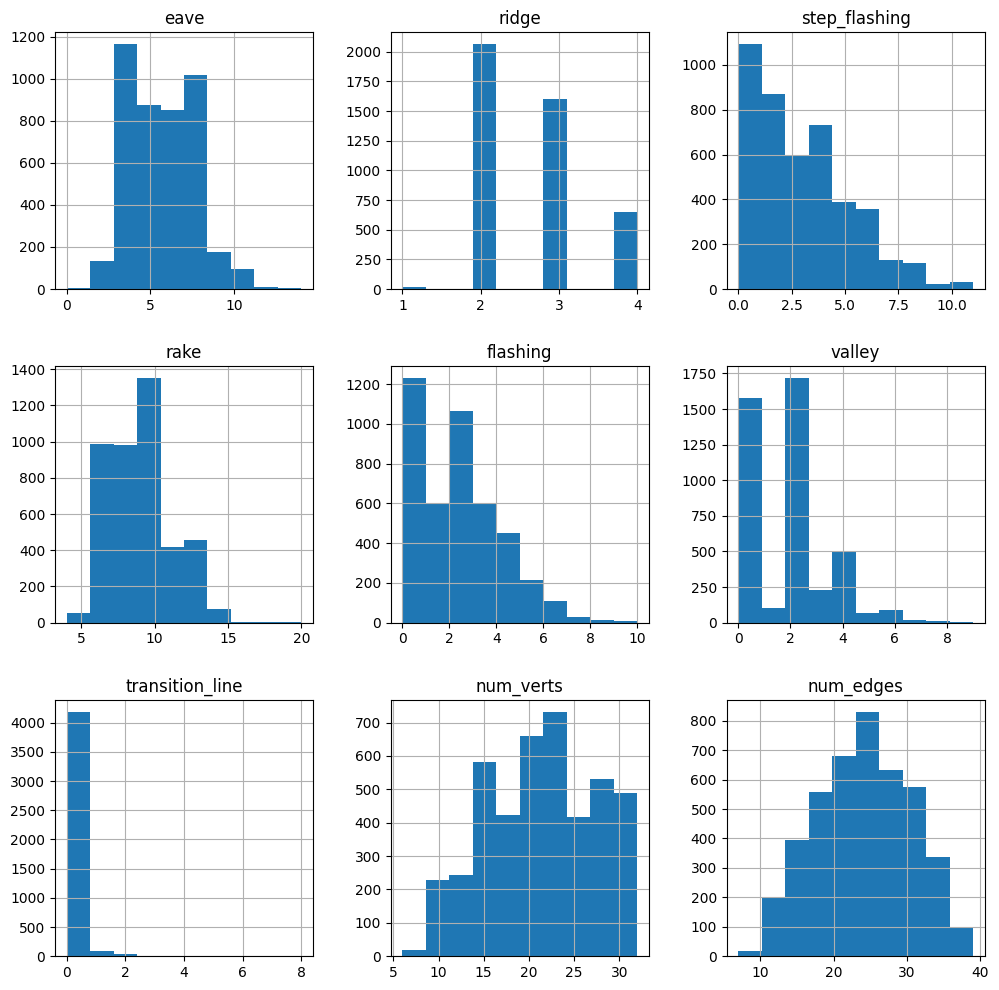

In [ ]:
df = counts.to_pandas()
df = df[ df.columns[df.max(0) != 0 ]]
df.set_index('__key__', inplace=True)
df.hist(figsize=(12,12))

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format('{:.2f}')



Text(0, 0.5, 'num_edges')

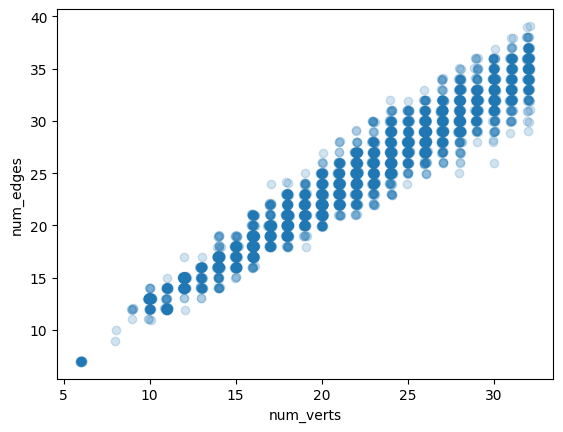

In [ ]:
xy = np.asarray(df[['num_verts', 'num_edges']]).T
xy = xy + np.random.randn(*xy.shape)*0.05
plt.scatter(*xy, alpha=.2)
plt.xlabel('num_verts')
plt.ylabel('num_edges')

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'eave'),
  Text(2, 0, 'ridge'),
  Text(3, 0, 'step_flashing'),
  Text(4, 0, 'rake'),
  Text(5, 0, 'flashing'),
  Text(6, 0, 'valley'),
  Text(7, 0, 'transition_line')])

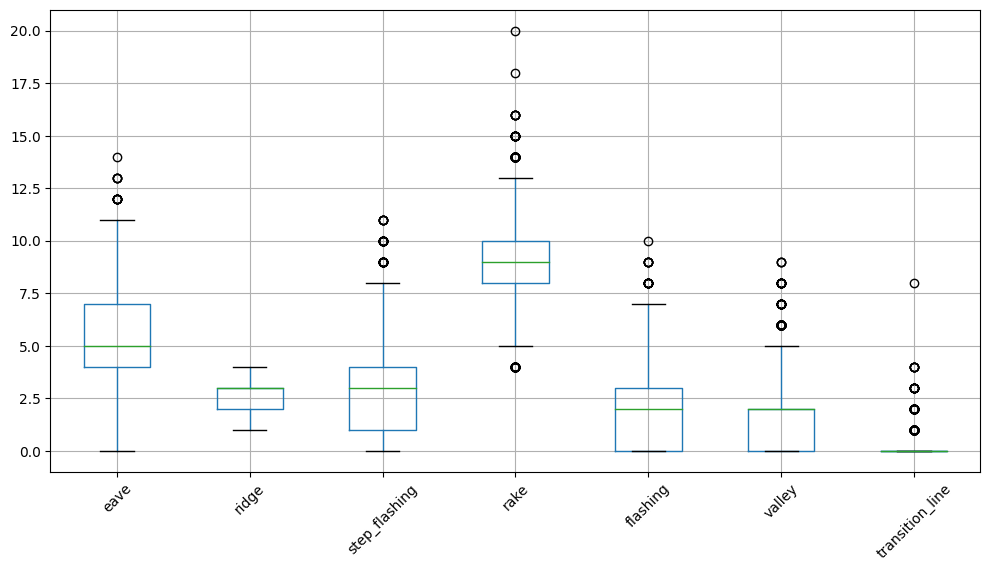

In [ ]:
df[[c for c in df.columns if not c in {'num_verts', 'num_edges'} ]].boxplot(figsize=(12, 6))
plt.xticks(rotation=45)

### Edge Length Statistics

In [ ]:
D = [s for i, s in enumerate(hoho.get_dataset(decode=None, split=split)) if i < 150]

In [ ]:
dataset = datasets.Dataset.from_list(D)
dataset

Dataset({
    features: ['__key__', '__imagekey__', '__url__', 'ade20k', 'depthcm', 'gestalt', 'wf_vertices', 'wf_edges', 'edge_semantics', 'mesh_vertices', 'mesh_faces', 'face_semantics', 'K', 'R', 't', 'images', 'points3d', 'cameras'],
    num_rows: 150
})

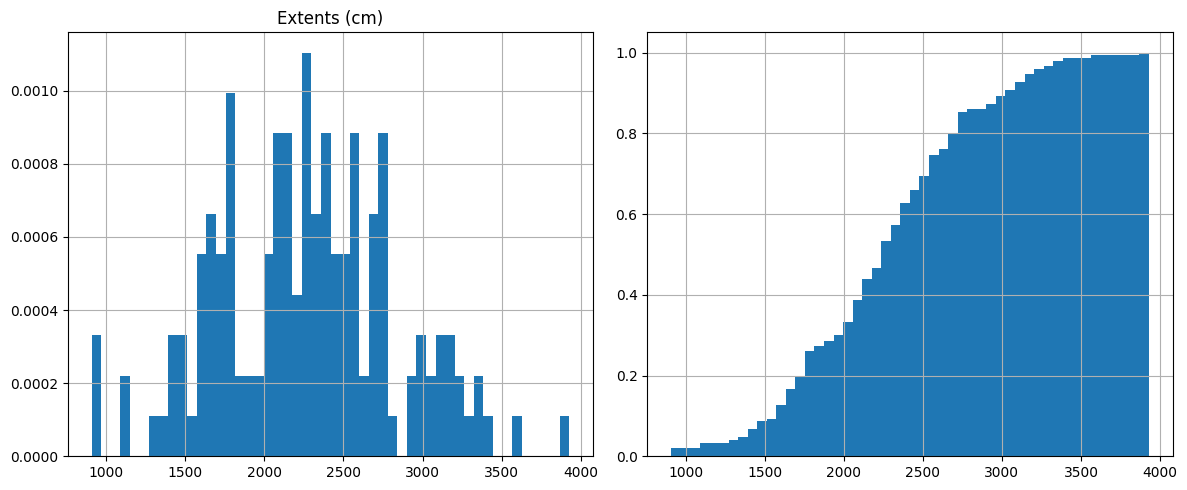

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
dataset.to_pandas()['wf_vertices'].apply(lambda x: np.sqrt((np.stack(x).ptp(0)**2).sum())).hist(density=True, cumulative=False, bins=50)
plt.title('Extents (cm)')

plt.subplot(122)
dataset.to_pandas()['wf_vertices'].apply(lambda x: np.sqrt((np.stack(x).ptp(0)**2).sum())).hist(density=True, cumulative=True, bins=50)

plt.tight_layout()

In [ ]:
edge_lengths = np.concatenate(dataset.map(lambda x: {'edge': np.linalg.norm(
                                np.diff(np.asarray(x['wf_vertices'])[np.asarray(x['wf_edges'])], axis=1),
                                             axis=-1).squeeze()
                      })['edge'])

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

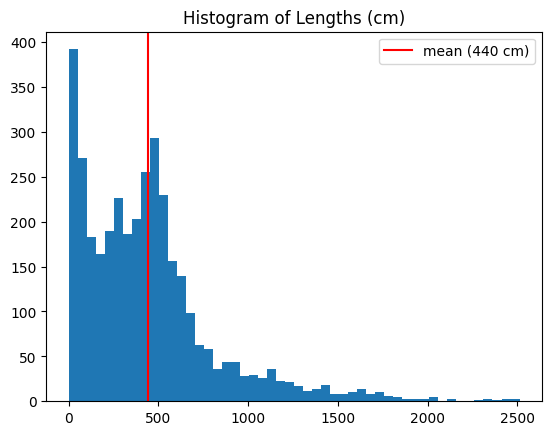

In [ ]:
mean_edge_length = np.mean(edge_lengths)

plt.hist(edge_lengths, bins=50)
plt.axvline(mean_edge_length, color='red', label=f'mean ({mean_edge_length:.0f} cm)')
plt.title('Histogram of Lengths (cm)')
plt.legend()
plt.show()

This edge length analysis was useful as very small or very large length edges can be pruned away for a better score.

## Visualizations

In [ ]:
dataset_item = next(iter(hoho.get_dataset(decode=None, split=split)))

In [ ]:
decoded_dataset_item = hoho.decode(dataset_item)
decoded_dataset_item

{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'PIL.WebPImagePlugin.WebPImageFile'>], 'depthcm': [<class 'PIL.PngImagePlugin.PngImageFile'>], 'gestalt': [<class 'PIL.WebPImagePlugin.WebPImageFile'>], 'wf_vertices': (30, 3), 'wf_edges': (32, 2), 'edge_semantics': (32,), 'mesh_vertices': (380, 3), 'mesh_faces': (236, 4), 'face_semantics': (236,), 'K': (3, 3, 3), 'R': (3, 3, 3), 't': (3, 3), 'images': <class 'dict'>, 'points3d': <class 'dict'>, 'cameras': <class 'dict'>}

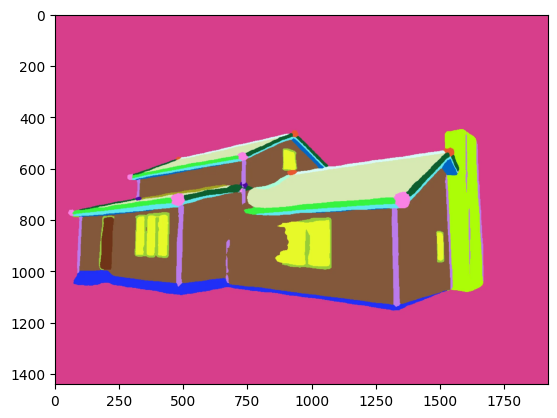

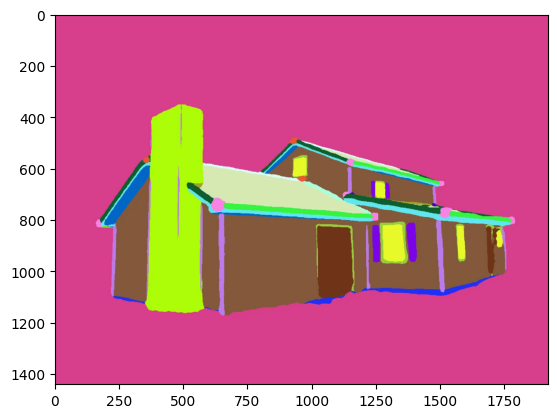

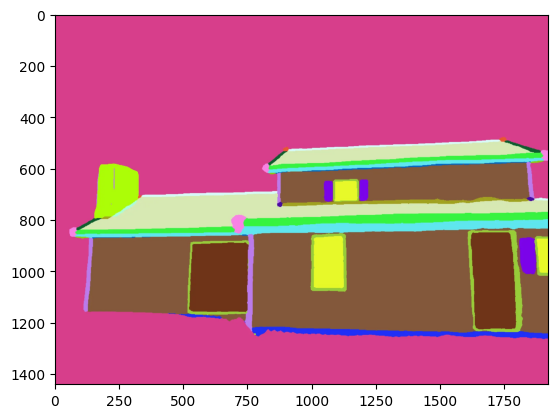

In [ ]:
for im in decoded_dataset_item["gestalt"]:
    plt.imshow(im)
    plt.show()

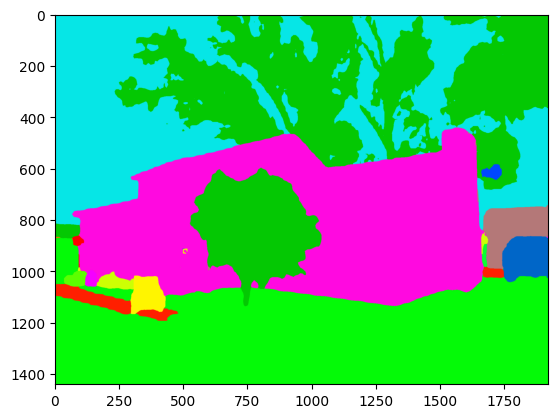

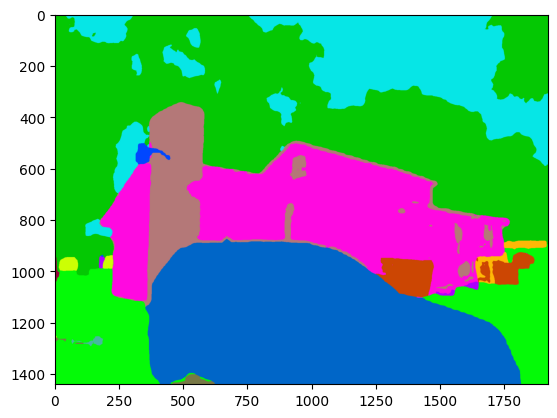

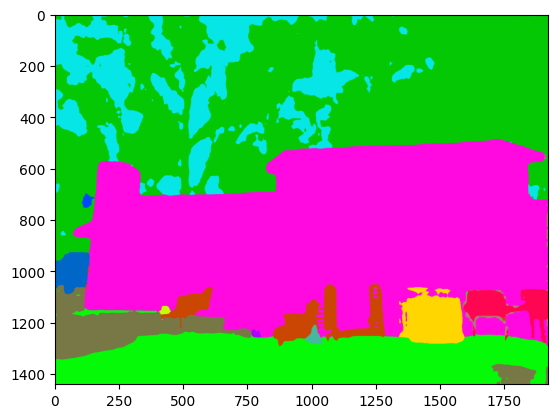

In [ ]:
for im in decoded_dataset_item["ade20k"]:
    plt.imshow(im)
    plt.show()

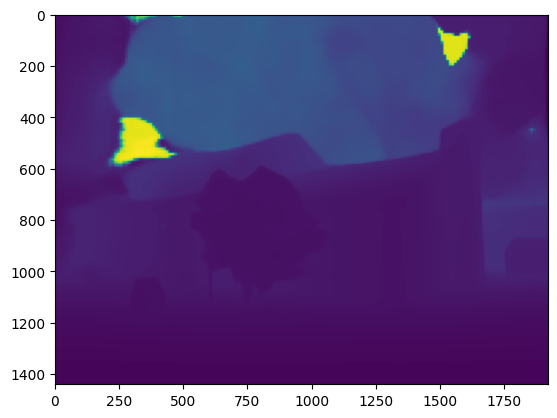

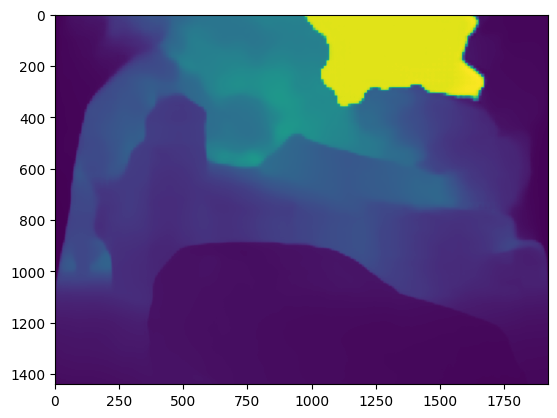

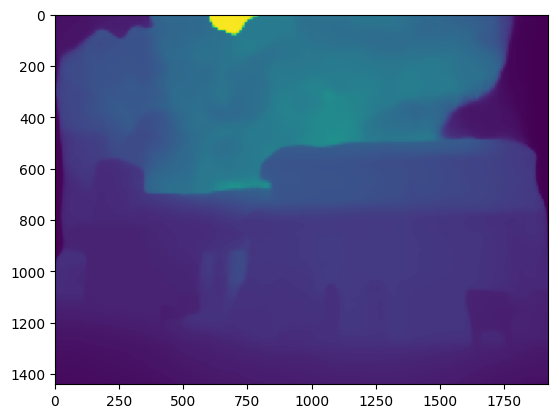

In [ ]:
from PIL import Image

im: Image
for im in decoded_dataset_item["depthcm"]:
    im = np.array(im)

    plt.imshow(im)
    plt.show()

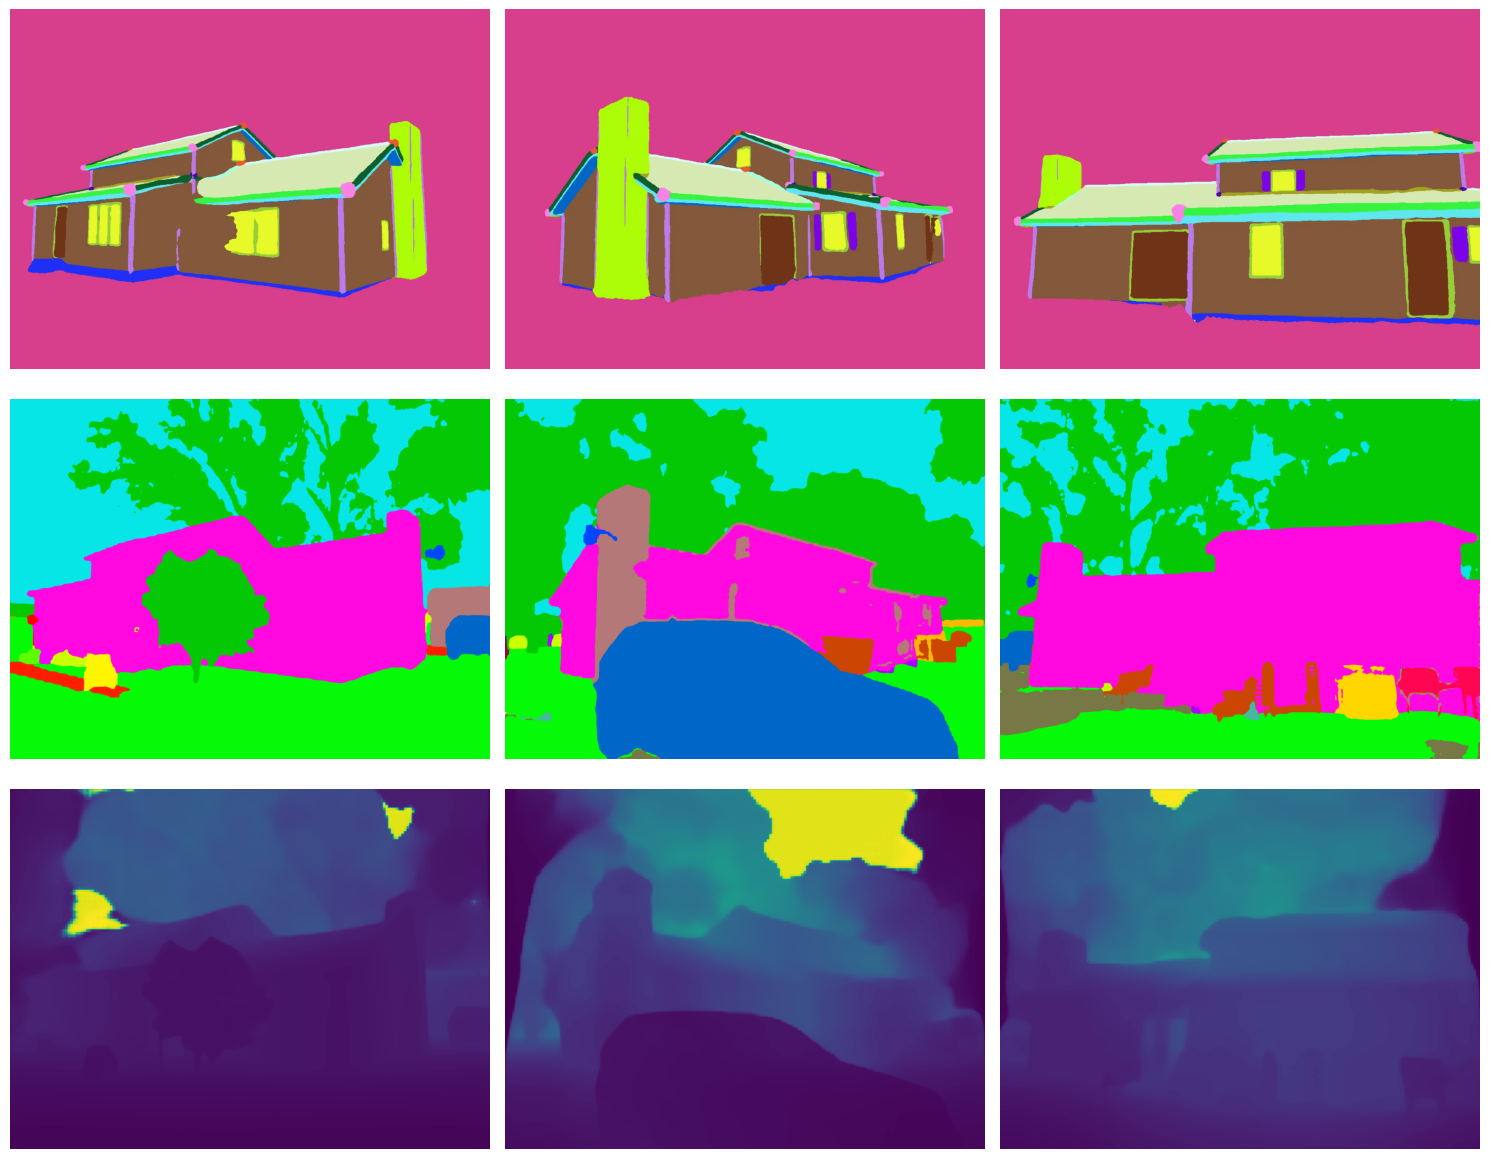

In [ ]:
all_images = []

for im in decoded_dataset_item["gestalt"]:
    all_images.append(im)

for im in decoded_dataset_item["ade20k"]:
    all_images.append(im)

for im in decoded_dataset_item["depthcm"]:
    im = np.array(im)
    all_images.append(im)

# Plot the images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    if i < len(all_images):
        ax.imshow(all_images[i])
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Define vertices and edges
wf_vertices = decoded_dataset_item['wf_vertices']

wf_edges = decoded_dataset_item['wf_edges']

fig = go.Figure()

# Add vertices
fig.add_trace(go.Scatter3d(
    x=wf_vertices[:, 0],
    y=wf_vertices[:, 1],
    z=wf_vertices[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Vertices'
))

# Add edges
for edge in wf_edges:
    start, end = edge
    fig.add_trace(go.Scatter3d(
        x=[wf_vertices[start, 0], wf_vertices[end, 0]],
        y=[wf_vertices[start, 1], wf_vertices[end, 1]],
        z=[wf_vertices[start, 2], wf_vertices[end, 2]],
        mode='lines',
        line=dict(color='blue', width=2),
        name='Edges'
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Visualization of Vertices and Edges'
)

fig.show()

In [ ]:
mesh_vertices = decoded_dataset_item['mesh_vertices']
mesh_faces = decoded_dataset_item['mesh_faces']
# Extract x, y, z coordinates from the vertices
x = mesh_vertices[:, 0]
y = mesh_vertices[:, 1]
z = mesh_vertices[:, 2]

# Extract the vertex indices for each face
i = mesh_faces[:, 1]
j = mesh_faces[:, 2]
k = mesh_faces[:, 3]

# Create a Mesh3d trace
mesh = go.Mesh3d(
    x=x,
    y=y,
    z=z,
    i=i,
    j=j,
    k=k,
    color='lightpink',
    opacity=0.50,
)

# Create a layout
layout = go.Layout(
    title='3D Mesh Plot',
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis')
    )
)

# Create a figure
fig = go.Figure(data=[mesh], layout=layout)

# Plot the figure
fig.show()

In [ ]:
points3d = decoded_dataset_item['points3d']
xyz_values = np.array([point.xyz for point in points3d.values()])
rgb_values = np.array([point.rgb for point in points3d.values()])

# Creating the scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=xyz_values[:, 0],
    y=xyz_values[:, 1],
    z=xyz_values[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=rgb_values,
        opacity=0.8
    )
))

# Setting plot layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)

# Showing the plot
fig.show()

Visualizing some samples

In [ ]:
D = [s for i, s in enumerate(hoho.get_dataset(decode=None, split=split)) if i < 150]
dataset = datasets.Dataset.from_list(D)
dataset

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning:

streaming isn't using with 'all': changing `split` to 'train'

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning:

no tarfiles found in ../data.



Dataset({
    features: ['__key__', '__imagekey__', '__url__', 'ade20k', 'depthcm', 'gestalt', 'wf_vertices', 'wf_edges', 'edge_semantics', 'mesh_vertices', 'mesh_faces', 'face_semantics', 'K', 'R', 't', 'images', 'points3d', 'cameras'],
    num_rows: 150
})

In [ ]:
grid = vis.show_grid(list(dataset.select(range(25)).to_pandas().apply(lambda x: vis.show_wf(x, radius=50), axis=1)), row_length=5).show()
with open('houses.html', 'w') as f:
    f.write(grid.data)

grid

In [ ]:
row_order = next(iter(hoho.get_dataset(decode=None, split=split).map(hoho.decode)))
row_order

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning:

streaming isn't using with 'all': changing `split` to 'train'

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning:

no tarfiles found in ../data.



{'__key__': <class 'str'>, '__imagekey__': [<class 'str'>], '__url__': <class 'str'>, 'ade20k': [<class 'PIL.WebPImagePlugin.WebPImageFile'>], 'depthcm': [<class 'PIL.PngImagePlugin.PngImageFile'>], 'gestalt': [<class 'PIL.WebPImagePlugin.WebPImageFile'>], 'wf_vertices': (30, 3), 'wf_edges': (32, 2), 'edge_semantics': (32,), 'mesh_vertices': (380, 3), 'mesh_faces': (236, 4), 'face_semantics': (236,), 'K': (3, 3, 3), 'R': (3, 3, 3), 't': (3, 3), 'images': <class 'dict'>, 'points3d': <class 'dict'>, 'cameras': <class 'dict'>}

In [ ]:

def to_K(f, cx, cy):
    K = np.eye(3)
    K[0,0] = K[1,1] = f
    K[0,2] = cx
    K[1,2] = cy
    return K

def quaternion_to_rotation_matrix(qvec):
    qw, qx, qy, qz = qvec
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])
    return R

col_cams = [hoho.Rt_to_eye_target(row_order['ade20k'][0], to_K(*row_order['cameras'][1].params), quaternion_to_rotation_matrix(colmap_img.qvec), colmap_img.tvec) for colmap_img in row_order['images'].values()]
eye, target, up, fov = col_cams[0]


cameras, images, points3D = row_order['cameras'], row_order['images'], row_order['points3d']
xyz = np.stack([p.xyz for p in points3D.values()])
color = np.stack([p.rgb for p in points3D.values()])
pcd = trimesh.Scene([trimesh.PointCloud(vertices=xyz, colors=color)])

V, E = row_order['wf_vertices'], row_order['wf_edges']
wf = vis.show_wf(row_order)

ax = [line((0,0,0), 1200*b, c=255*b, radius=15) for b in np.eye(3)]

u = trimesh.Trimesh(vertices=row_order['mesh_vertices'] , faces=row_order['mesh_faces'][:, 1:])

cams = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6) for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[row_order[k] for k in 'ade20k K R t'.split()]))])
cams_colmap = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6, c=(0,0,255)) for eye, target, up, fov in col_cams])


trimesh.Scene([
        u,
        ax,
        cams,
        cams_colmap,
        pcd,
        *wf
    ]).show()

The above visualization suggest that there is a lot of inaccuracy in point cloud data. So considering direct mesh reconstruction techniques from point cloud will also be very penalizing.

# Pointcloud and Depthmap estimation

In [ ]:
split = "all"
samples = []
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    if i > 10:
        break
    samples.append((hoho.decode(sample)))


/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning: streaming isn't using with 'all': changing `split` to 'train'
  warnings.warn('streaming isn\'t using with \'all\': changing `split` to \'train\'')
/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning: no tarfiles found in ../data.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
11it [00:05,  2.00it/s]


## Getting Sparse Depth map from projected point cloud

In [ ]:
decoded_dataset_item = samples[0]

In [ ]:
def hoho_image_to_pycolmap(hoho_image, biggest_cluster_keys) -> pc.Image:
    points_2d = []
    for xy, point3D_id in zip(hoho_image.xys, hoho_image.point3D_ids):
        if point3D_id in biggest_cluster_keys:
            points_2d.append(pc.Point2D(xy=xy, point3D_id=point3D_id))
    return pc.Image(name = hoho_image.name,
             camera_id = hoho_image.camera_id,
             points2D = points_2d,
             cam_from_world = pc.Rigid3d(hoho_image.qvec, hoho_image.tvec),
             id = hoho_image.id)


In [ ]:
points = [v.xyz for k, v in decoded_dataset_item["points3d"].items()]
point_keys = [k for k, v in decoded_dataset_item["points3d"].items()]
clustered = DBSCAN(eps=120, min_samples=10).fit(points).labels_
clustered_indices = np.argsort(clustered)
points = np.array(points)
points = points[clustered_indices]
point_keys = np.array(point_keys)[clustered_indices]
clustered = clustered[clustered_indices]
_, cluster_indices = np.unique(clustered, return_index=True)
clustered_points = np.split(points, cluster_indices[1:])
clustered_keys = np.split(point_keys, cluster_indices[1:])
biggest_cluster_index = np.argmax([len(i) for i in clustered_points])
biggest_cluster = clustered_points[biggest_cluster_index]
biggest_cluster_keys = clustered_keys[biggest_cluster_index]
biggest_cluster_keys = set(biggest_cluster_keys)

In [ ]:
image_dict: dict[str, pc.Image] = {}
for k,v in decoded_dataset_item["images"].items():
    image_dict[v.name] = hoho_image_to_pycolmap(v, biggest_cluster_keys)


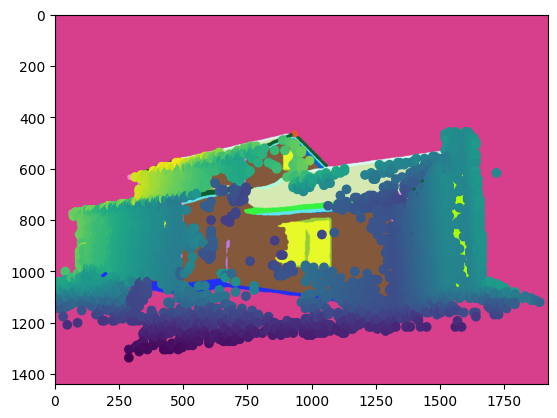

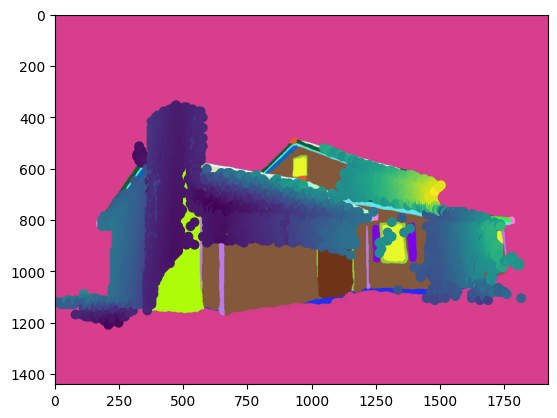

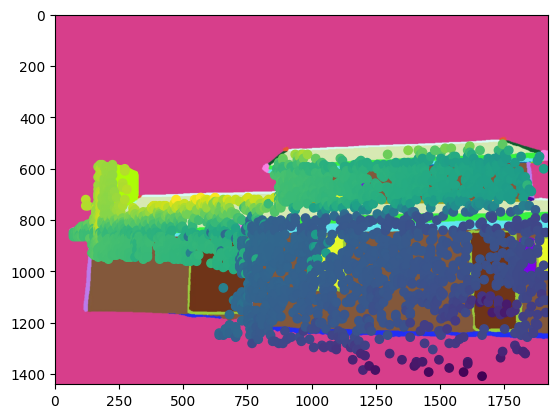

In [ ]:
for image_idx in range(len(decoded_dataset_item["__imagekey__"])):
    belonging_points3d = []
    belonging_points2d = []
    image_key = decoded_dataset_item["__imagekey__"][image_idx]
    image: pc.Image = image_dict[image_key]
    cam_from_world = image.cam_from_world.matrix()


    points3D_ids = (i.point3D_id for i in image.get_valid_points2D())

    points_3d = np.array([decoded_dataset_item["points3d"][i].xyz for i in points3D_ids])

    # Define the 3D points to project
    points2D = np.array([i.xy for i in image.get_valid_points2D()])

    K = decoded_dataset_item["K"][image_idx]
    R = decoded_dataset_item["R"][image_idx]
    t = decoded_dataset_item["t"][image_idx]


    world_to_cam = np.eye(4)
    world_to_cam[:3, :3] = R
    world_to_cam[:3, 3] = t
    #

    homo_belonging_points = cv2.convertPointsToHomogeneous(points_3d)
    depths = cv2.convertPointsFromHomogeneous(cv2.transform(homo_belonging_points, world_to_cam))
    depths = depths[:,0,:]

    plt.imshow(decoded_dataset_item["gestalt"][image_idx])
    plt.scatter(points2D[:, 0], points2D[:, 1], c=depths[:, 2])
    plt.show()

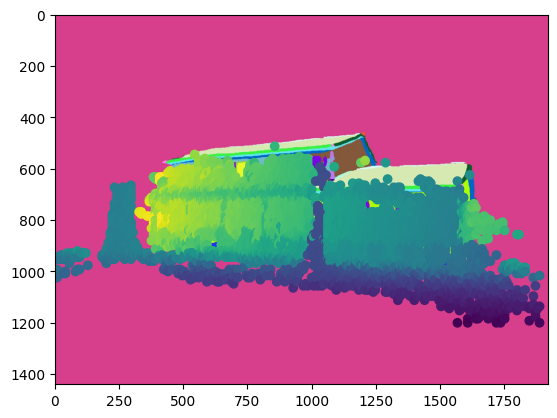

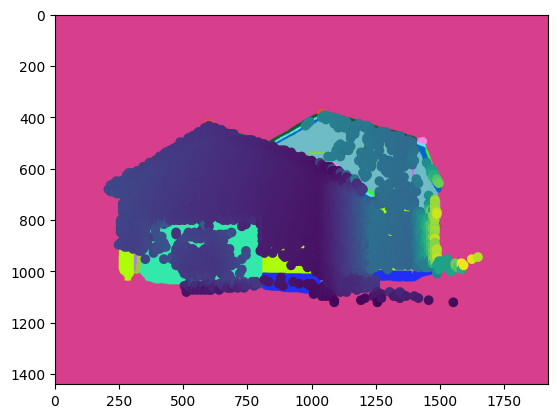

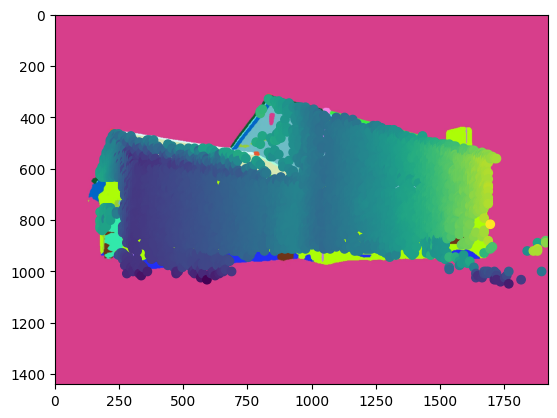

In [ ]:
decoded_dataset_item = samples[5]
points = [v.xyz for k, v in decoded_dataset_item["points3d"].items()]
point_keys = [k for k, v in decoded_dataset_item["points3d"].items()]
clustered = DBSCAN(eps=120, min_samples=10).fit(points).labels_
clustered_indices = np.argsort(clustered)
points = np.array(points)
points = points[clustered_indices]
point_keys = np.array(point_keys)[clustered_indices]
clustered = clustered[clustered_indices]
_, cluster_indices = np.unique(clustered, return_index=True)
clustered_points = np.split(points, cluster_indices[1:])
clustered_keys = np.split(point_keys, cluster_indices[1:])
biggest_cluster_index = np.argmax([len(i) for i in clustered_points])
biggest_cluster = clustered_points[biggest_cluster_index]
biggest_cluster_keys = clustered_keys[biggest_cluster_index]
biggest_cluster_keys = set(biggest_cluster_keys)
image_dict: dict[str, pc.Image] = {}
for k,v in decoded_dataset_item["images"].items():
    image_dict[v.name] = hoho_image_to_pycolmap(v, biggest_cluster_keys)




for image_idx in range(len(decoded_dataset_item["__imagekey__"])):
    belonging_points3d = []
    belonging_points2d = []
    image_key = decoded_dataset_item["__imagekey__"][image_idx]
    image: pc.Image = image_dict[image_key]
    cam_from_world = image.cam_from_world.matrix()


    points3D_ids = (i.point3D_id for i in image.get_valid_points2D())

    points_3d = np.array([decoded_dataset_item["points3d"][i].xyz for i in points3D_ids])

    # Define the 3D points to project
    points2D = np.array([i.xy for i in image.get_valid_points2D()])

    K = decoded_dataset_item["K"][image_idx]
    R = decoded_dataset_item["R"][image_idx]
    t = decoded_dataset_item["t"][image_idx]


    world_to_cam = np.eye(4)
    world_to_cam[:3, :3] = R
    world_to_cam[:3, 3] = t
    #

    homo_belonging_points = cv2.convertPointsToHomogeneous(points_3d)
    depths = cv2.convertPointsFromHomogeneous(cv2.transform(homo_belonging_points, world_to_cam))
    depths = depths[:,0,:]

    plt.imshow(decoded_dataset_item["gestalt"][image_idx])
    plt.scatter(points2D[:, 0], points2D[:, 1], c=depths[:, 2])
    plt.show()

## Depthmap Estimation by Neighbours

In [ ]:
class NearestNDInterpolatorWithThreshold(si.NearestNDInterpolator):
    def __init__(self, points, values, max_distance):
        super().__init__(points, values)
        self.max_distance = max_distance
        self.tree = cKDTree(points)

    def __call__(self, *args):
        # Convert the input to a 2D array of query points
        query_points = np.array(args).T
        distances, indices = self.tree.query(query_points)
        values = np.full(query_points.shape[:-1], np.nan)
        valid_mask = distances <= self.max_distance
        values[valid_mask] = self.values[indices[valid_mask]]
        return values.T

In [ ]:
from scipy.spatial import cKDTree

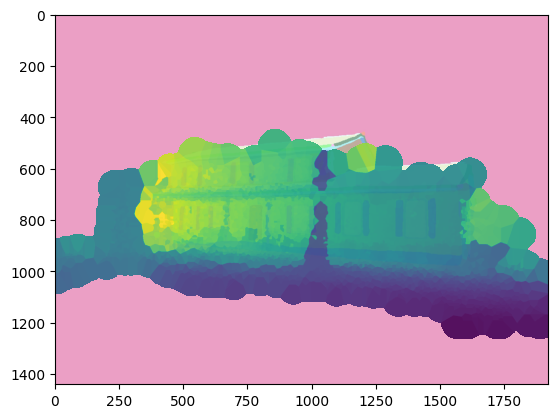

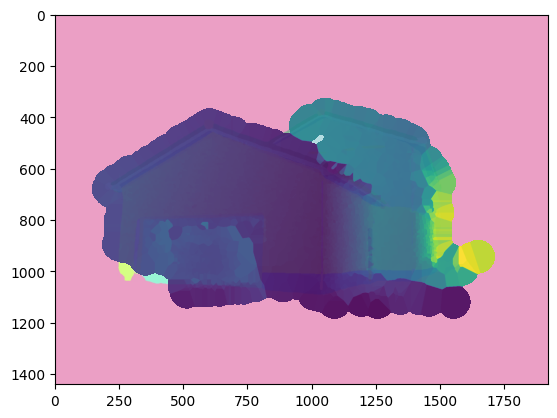

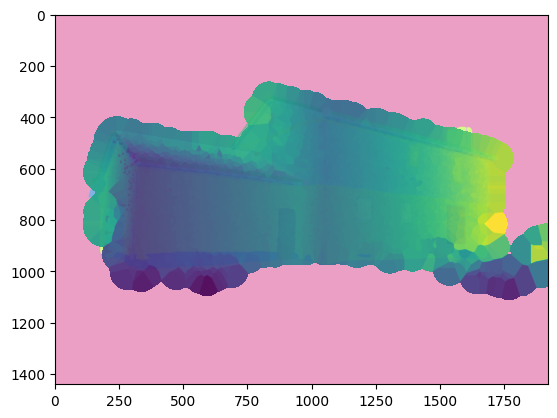

In [ ]:
for image_idx in range(len(decoded_dataset_item["__imagekey__"])):
  belonging_points3d = []
  belonging_points2d = []
  image_key = decoded_dataset_item["__imagekey__"][image_idx]
  image: pc.Image = image_dict[image_key]
  cam_from_world = image.cam_from_world.matrix()
  points3D_ids = (i.point3D_id for i in image.get_valid_points2D())
  points_3d = np.array([decoded_dataset_item["points3d"][i].xyz for i in points3D_ids])
  # Define the 3D points to project
  points2D = np.array([i.xy for i in image.get_valid_points2D()])
  K = decoded_dataset_item["K"][image_idx]
  R = decoded_dataset_item["R"][image_idx]
  t = decoded_dataset_item["t"][image_idx]

  world_to_cam = np.eye(4)
  world_to_cam[:3, :3] = R
  world_to_cam[:3, 3] = t
  #

  homo_belonging_points = cv2.convertPointsToHomogeneous(points_3d)
  depths = cv2.convertPointsFromHomogeneous(cv2.transform(homo_belonging_points, world_to_cam))
  depths = depths[:,0,:]
  interpolator = NearestNDInterpolatorWithThreshold(points2D, depths[:,2], 70)
  depthcm = np.array(decoded_dataset_item["depthcm"][image_idx])
  xi, yi = np.meshgrid(np.arange(depthcm.shape[1]), np.arange(depthcm.shape[0]))
  interpolated = interpolator(xi, yi)
  plt.imshow(decoded_dataset_item["gestalt"][image_idx], alpha=0.5)
  plt.imshow(interpolated, alpha=0.9)
  plt.show()

## Monocular Depthmaps scaling with interpolation

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr

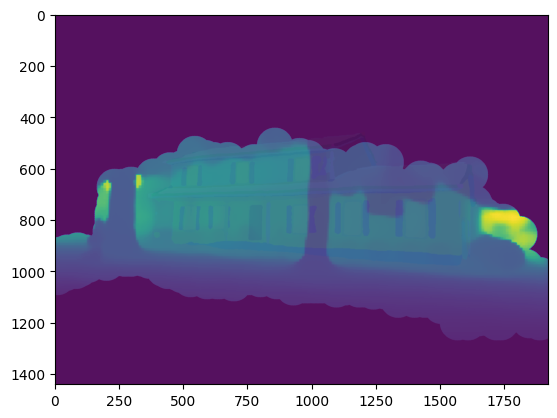

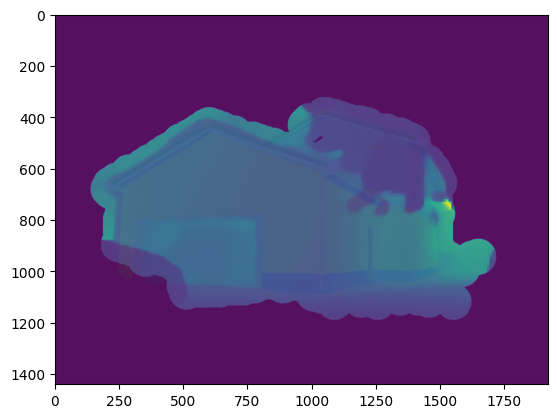

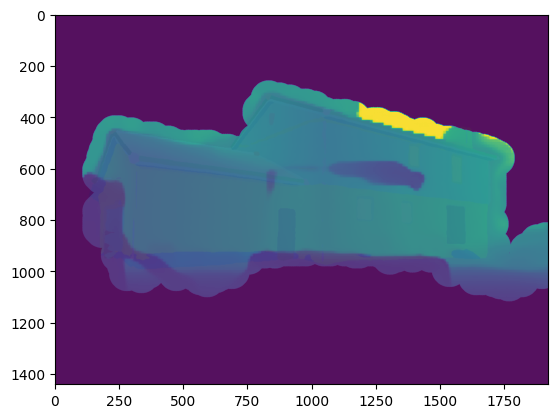

In [ ]:
for image_idx in range(len(decoded_dataset_item["__imagekey__"])):
  belonging_points3d = []
  belonging_points2d = []
  image_key = decoded_dataset_item["__imagekey__"][image_idx]
  image: pc.Image = image_dict[image_key]
  cam_from_world = image.cam_from_world.matrix()
  points3D_ids = (i.point3D_id for i in image.get_valid_points2D())
  points_3d = np.array([decoded_dataset_item["points3d"][i].xyz for i in points3D_ids])
  # Define the 3D points to project
  points2D = np.array([i.xy for i in image.get_valid_points2D()])
  K = decoded_dataset_item["K"][image_idx]
  R = decoded_dataset_item["R"][image_idx]
  t = decoded_dataset_item["t"][image_idx]

  world_to_cam = np.eye(4)
  world_to_cam[:3, :3] = R
  world_to_cam[:3, 3] = t
  #

  homo_belonging_points = cv2.convertPointsToHomogeneous(points_3d)
  depths = cv2.convertPointsFromHomogeneous(cv2.transform(homo_belonging_points, world_to_cam))
  depths = depths[:,0,:]
  interpolator = NearestNDInterpolatorWithThreshold(points2D, depths[:,2], 70)
  depthcm = np.array(decoded_dataset_item["depthcm"][image_idx])
  xi, yi = np.meshgrid(np.arange(depthcm.shape[1]), np.arange(depthcm.shape[0]))
  interpolated = interpolator(xi, yi)
  D = np.array(depthcm)
  G = np.array(interpolated)
  min_length = min(len(D), len(G))
  D = D[:min_length]
  G = G[:min_length]
  mask = ~np.isnan(G)
  D = D[mask]
  G  = G[mask]
  X = np.vstack([D]).T
  # Compute the least squares solution
  a = np.linalg.lstsq(X, G, rcond=None)[0]
  D_fitted = a * D
  D_empty = np.zeros_like(mask).astype(np.float32)
  D_empty[mask] = D_fitted
  plt.imshow(decoded_dataset_item["gestalt"][image_idx], alpha=0.5)
  plt.imshow(D_empty, alpha=0.9)
  plt.show()

# Vertex Detection

In [ ]:
decoded_dataset_item = samples[2]

In [ ]:
from hoho.color_mappings import gestalt_color_mapping
apex_color = gestalt_color_mapping["apex"]
eave_end_point = gestalt_color_mapping["eave_end_point"]
flashing_end_point = gestalt_color_mapping["flashing_end_point"]

apex_color, eave_end_point, flashing_end_point = [np.array(i) for i in [apex_color, eave_end_point, flashing_end_point]]

line_classes = ['eave', 'ridge', 'rake', 'valley']

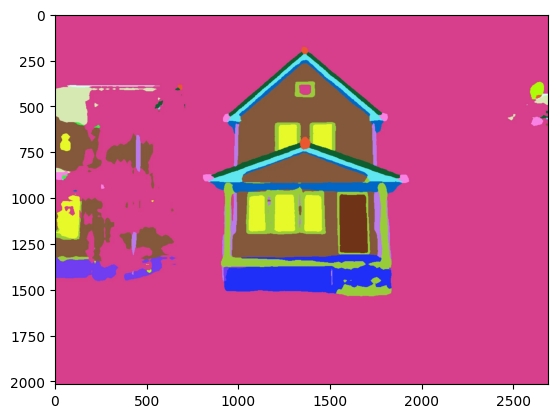

In [ ]:
plt.imshow(decoded_dataset_item["gestalt"][0])

In [ ]:
unclassified = np.array([(215, 62, 138)])

In [ ]:
image_gestalt = decoded_dataset_item["gestalt"][0]
image_gestalt = np.array(image_gestalt)
unclassified_mask = cv2.inRange(image_gestalt, unclassified + 0.0, unclassified + 0.8)
unclassified_mask = cv2.bitwise_not(unclassified_mask)
mask = undesired_objects(unclassified_mask).astype(np.uint8)

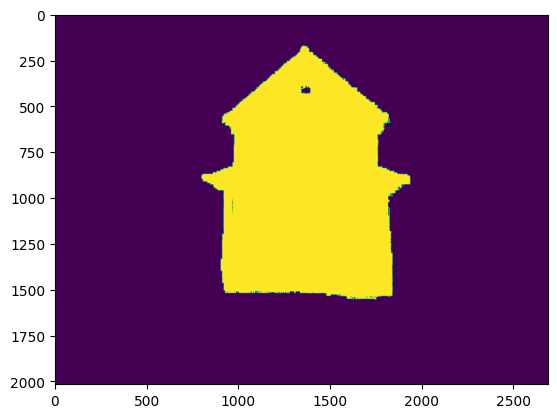

In [ ]:
plt.imshow(mask)

In [ ]:
def undesired_objects(image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    return img2

def clean_image(image_gestalt) -> np.ndarray:
    # clears image in from of unclassified and disconected components
    image_gestalt = np.array(image_gestalt)
    unclassified_mask = cv2.inRange(image_gestalt, unclassified - 1., unclassified + 1.)
    unclassified_mask = cv2.bitwise_not(unclassified_mask)
    mask = undesired_objects(unclassified_mask).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((11, 11), np.uint8), iterations=11)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((11, 11), np.uint8), iterations=2)
    image_gestalt[:, :, 0] *= mask
    image_gestalt[:, :, 1] *= mask
    image_gestalt[:, :, 2] *= mask
    return image_gestalt


def get_vertices(image_gestalt, *, color_range=4., dialations=3, erosions=1, kernel_size=13):

    apex_mask = cv2.inRange(image_gestalt, apex_color - color_range, apex_color + color_range)
    eave_end_point_mask = cv2.inRange(image_gestalt, eave_end_point - color_range, eave_end_point + color_range)
    flashing_end_point_mask = cv2.inRange(image_gestalt, flashing_end_point - color_range, flashing_end_point + color_range)
    eave_end_point_mask = cv2.bitwise_or(eave_end_point_mask, flashing_end_point_mask)

    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    apex_mask = cv2.morphologyEx(apex_mask, cv2.MORPH_DILATE, kernel, iterations=dialations)
    apex_mask = cv2.morphologyEx(apex_mask, cv2.MORPH_ERODE, kernel, iterations=erosions)

    eave_end_point_mask = cv2.morphologyEx(eave_end_point_mask, cv2.MORPH_DILATE, kernel, iterations=dialations)
    eave_end_point_mask = cv2.morphologyEx(eave_end_point_mask, cv2.MORPH_ERODE, kernel, iterations=erosions)

    *_, apex_centroids = cv2.connectedComponentsWithStats(apex_mask, connectivity=8, stats=cv2.CV_32S)
    *_, other_centroids = cv2.connectedComponentsWithStats(eave_end_point_mask, connectivity=8, stats=cv2.CV_32S)

    return apex_centroids[1:], other_centroids[1:], apex_mask, eave_end_point_mask

def infer_vertices(image_gestalt, *, color_range=4.):
    ridge_color = np.array(gestalt_color_mapping["ridge"])
    rake_color = np.array(gestalt_color_mapping["rake"])
    ridge_mask = cv2.inRange(image_gestalt,
                             ridge_color-color_range,
                             ridge_color+color_range)
    ridge_mask = cv2.morphologyEx(ridge_mask,
                                  cv2.MORPH_DILATE, np.ones((3, 3)), iterations=5)
    rake_mask = cv2.inRange(image_gestalt,
                            rake_color-color_range,
                            rake_color+color_range)
    rake_mask = cv2.morphologyEx(rake_mask,
                                 cv2.MORPH_DILATE, np.ones((3, 3)), iterations=5)

    intersection_mask = cv2.bitwise_and(ridge_mask, rake_mask)
    intersection_mask = cv2.morphologyEx(intersection_mask, cv2.MORPH_DILATE, np.ones((11, 11)), iterations=3)


    *_, inferred_centroids = cv2.connectedComponentsWithStats(intersection_mask, connectivity=8, stats=cv2.CV_32S)

    return inferred_centroids[1:], intersection_mask

def get_missed_vertices(vertices, inferred_centroids, *, max_inferred_distance=20.):
    vertices = KDTree(vertices)
    closest = vertices.query(inferred_centroids, k=1, distance_upper_bound=max_inferred_distance)
    missed_points = inferred_centroids[closest[1] == len(vertices.data)]
    return missed_points

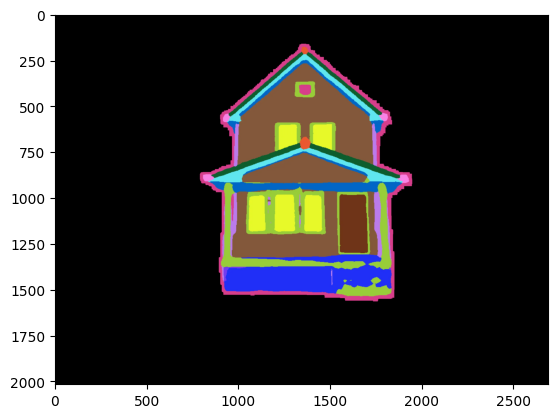

In [ ]:
image_gestalt = decoded_dataset_item["gestalt"][0]
image_gestalt = clean_image(image_gestalt)
plt.imshow(image_gestalt)

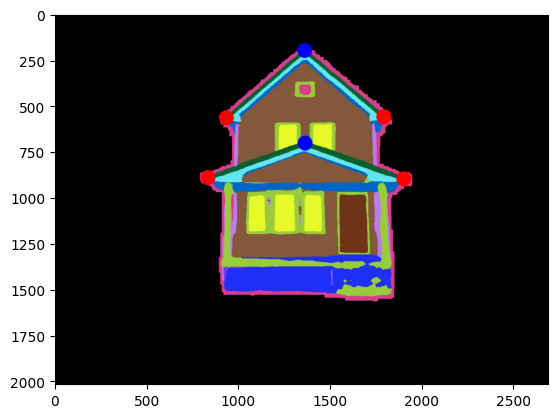

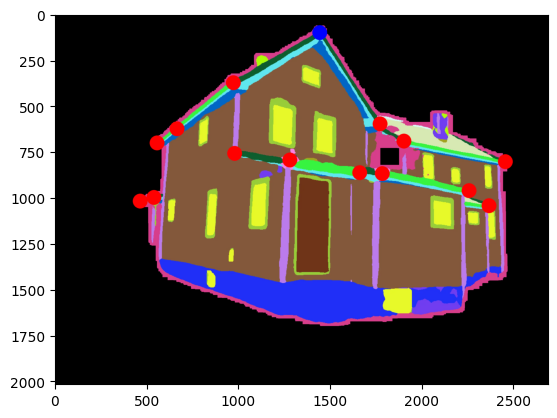

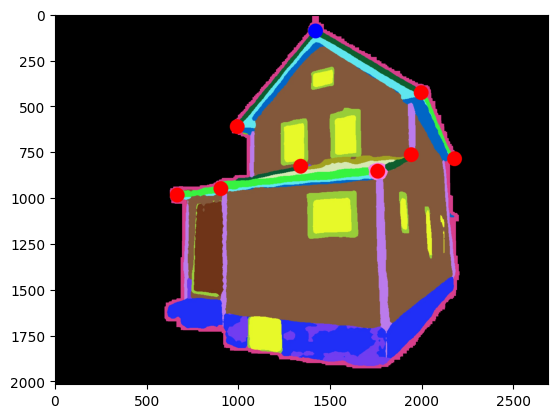

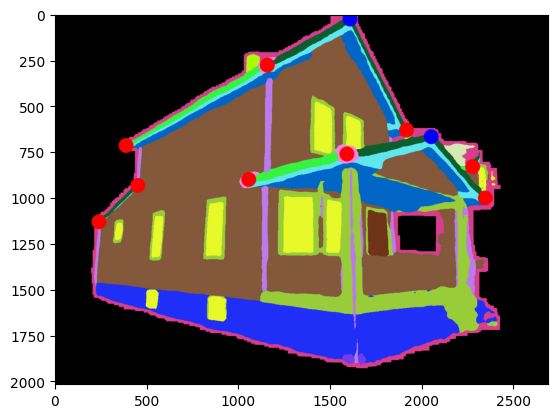

In [ ]:
modified_images = []
for im, image_gestalt, im_d in zip(decoded_dataset_item["ade20k"], decoded_dataset_item["gestalt"],
                          decoded_dataset_item["depthcm"]):
    im = np.array(im)
    im_d = np.array(im_d)

    image_gestalt = clean_image(image_gestalt)
    apex_centroids, other_centroids, *_ = get_vertices(image_gestalt)
    for vertex in apex_centroids:
        cv2.circle(image_gestalt, vertex.astype(np.int32), 20, (0, 0, 255), 40, -1)

    for vertex in other_centroids:
        cv2.circle(image_gestalt, vertex.astype(np.int32), 20, (255, 0, 0), 40, -1)

    plt.imshow(image_gestalt)
    plt.show()

    modified_images.append(image_gestalt)



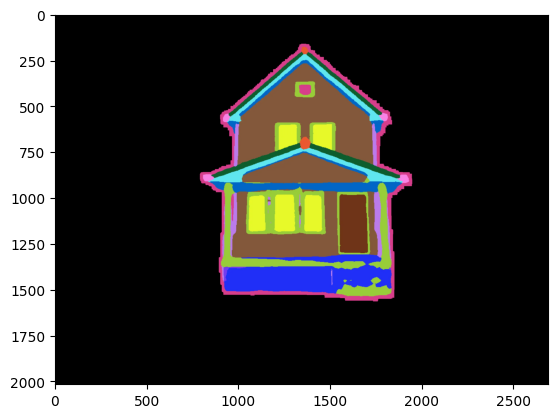

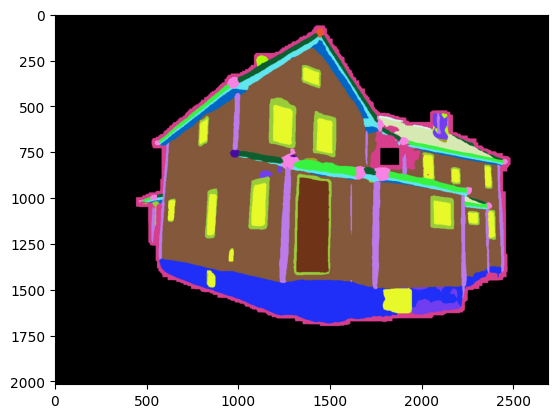

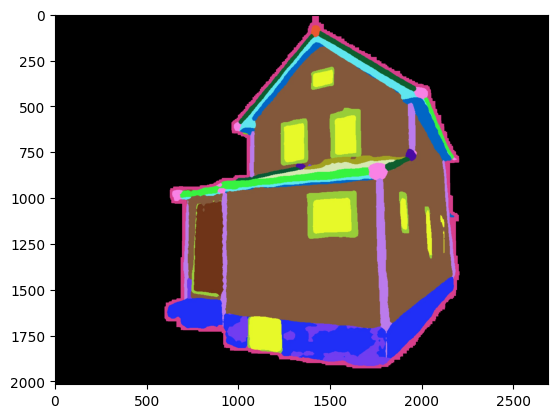

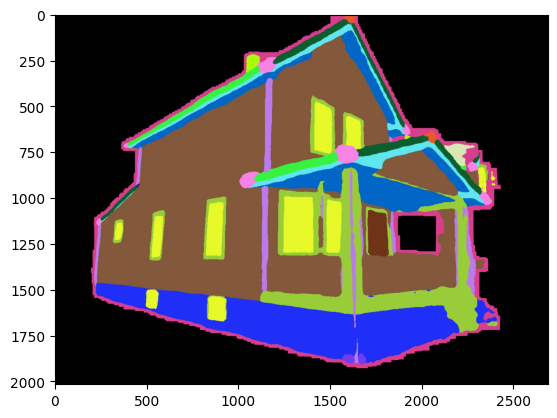

In [ ]:
modified_images = []
for im, image_gestalt, im_d in zip(decoded_dataset_item["ade20k"], decoded_dataset_item["gestalt"],
                          decoded_dataset_item["depthcm"]):
    im = np.array(im)
    im_d = np.array(im_d)

    image_gestalt = clean_image(image_gestalt)




    plt.imshow(image_gestalt)
    plt.show()

    modified_images.append(image_gestalt)



# Line Detection

In [ ]:
import cv2
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors

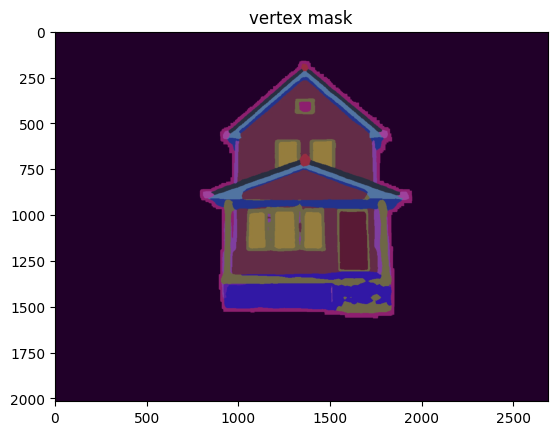

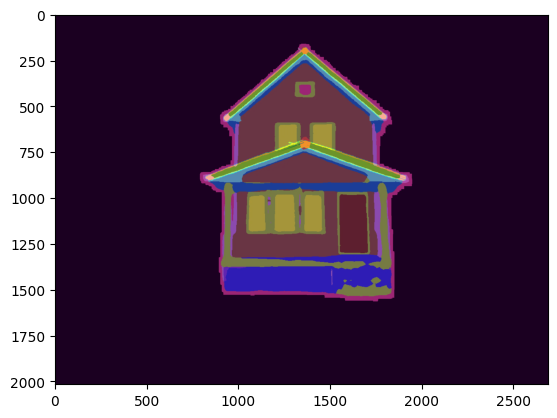

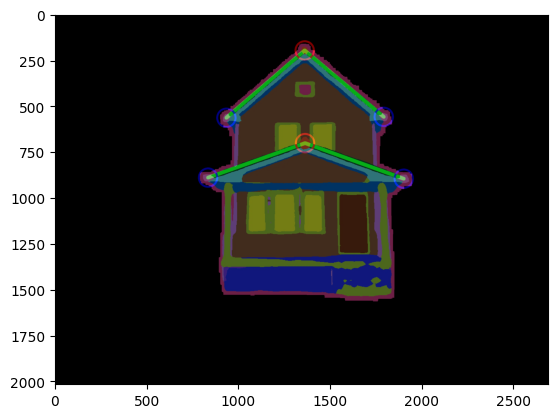

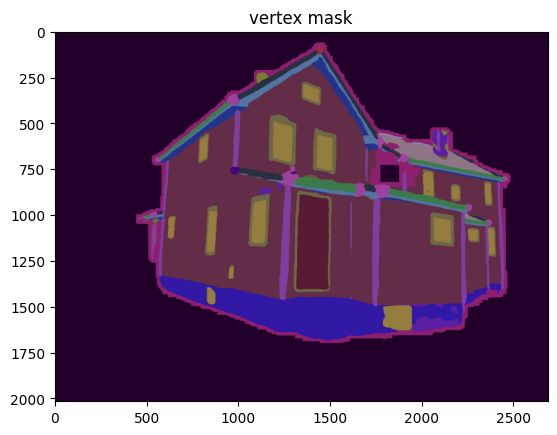

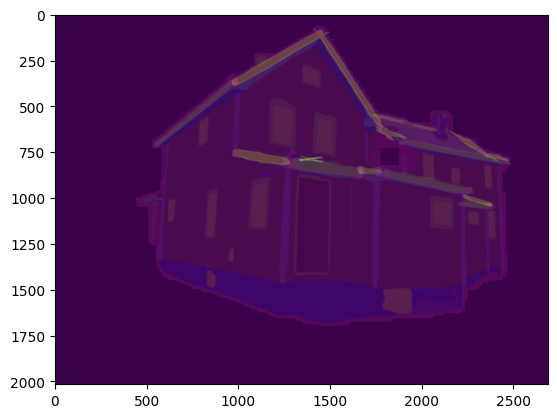

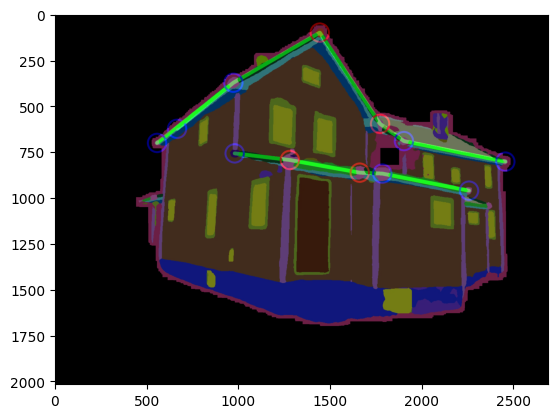

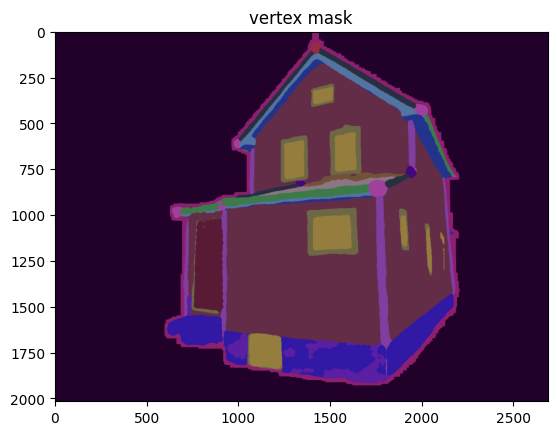

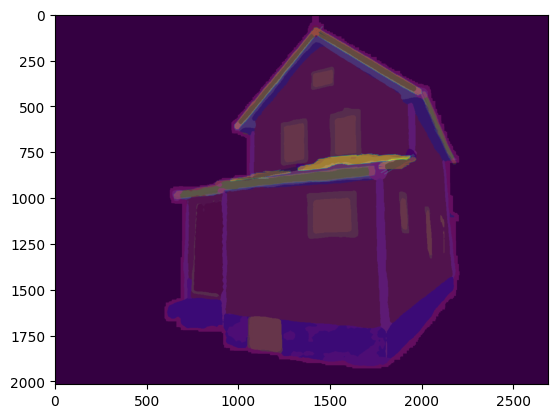

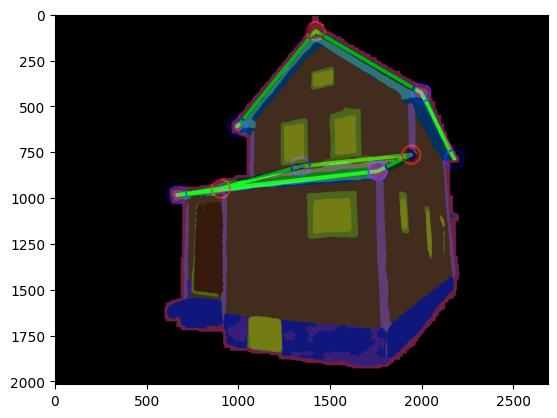

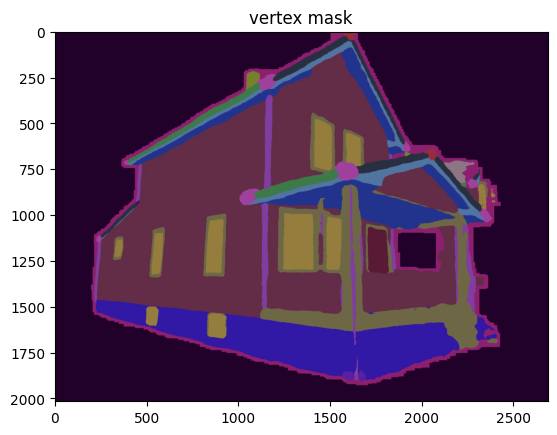

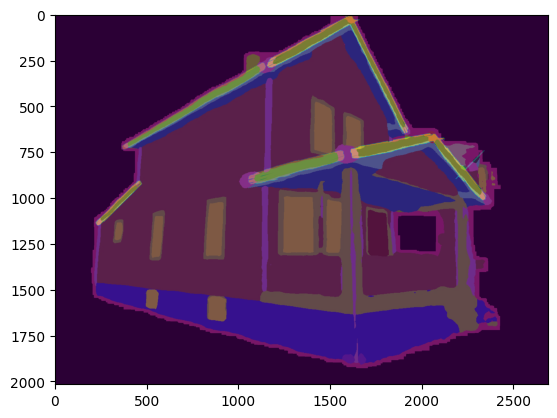

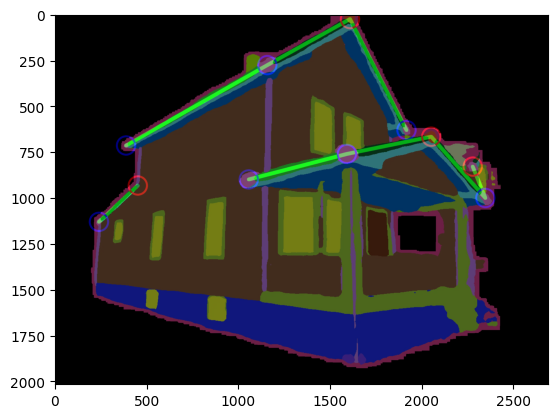

In [ ]:
# cleaned_image = clean_image(gest_seg_np)

SHOW_MASKS = True
SHOW_CONNECTIONS = True
edge_th = 60.
edge_th = edge_th ** 2
color_range = 4.
max_depth = 40
point_radius = 25*2
max_angle = 15
extend = 30
deviation_threshold = np.cos(np.deg2rad(max_angle))
for im, image_gestalt, depth in zip(decoded_dataset_item["ade20k"], decoded_dataset_item["gestalt"],
                                   decoded_dataset_item["depthcm"]):

    image_gestalt = image_gestalt.resize(depth.size)
    image_gestalt = clean_image(image_gestalt)


    connections = []


    # Metric3D
    depth_np = np.array(depth) # 2.5 is the scale estimation coefficient

    cv2.normalize(depth_np, depth_np, 0, max_depth, cv2.NORM_MINMAX)



    # gest_seg_np = cv2.cvtColor(gest_seg_np, cv2.COLOR_RGB2HSV)
    gest_seg_np = image_gestalt

    apex_centroids, eave_end_point_centroids, apex_mask, eave_end_point_mask = get_vertices(gest_seg_np)
    apex_mask = cv2.morphologyEx(apex_mask,
                                 cv2.MORPH_DILATE, np.ones((11, 11)), iterations=4)

    vertices = np.concatenate([apex_centroids, eave_end_point_centroids])
    inferred_vertices, inferred_mask = infer_vertices(gest_seg_np)
    missed_vertices = get_missed_vertices(vertices, inferred_vertices)
    vertices = np.concatenate([vertices, missed_vertices])
    if (len(vertices) < 2):
        continue
    # vertices = KDTree(vertices)


    vertex_size = np.zeros(vertices.shape[0])
    eave_end_point_size = np.zeros_like(eave_end_point_mask)

    scale = 2
    vertex_mask = np.zeros_like(apex_mask)
    vertices = KDTree(vertices)

    if SHOW_MASKS:
        vertex_mask = np.bitwise_not(vertex_mask)
        plt.imshow(gest_seg_np)
        plt.imshow(vertex_mask, alpha=0.5)
        plt.title("vertex mask")
        plt.show()
        # plt.imshow(depth_np)
        # plt.show()


    if SHOW_MASKS:
        plt.imshow(gest_seg_np)


    for edge_class in ['eave', 'ridge', 'rake', 'valley', 'flashing', 'step_flashing']:
        edge_color = np.array(gestalt_color_mapping[edge_class])

        mask = cv2.inRange(gest_seg_np,
                           edge_color-color_range,
                           edge_color+color_range)
        mask = cv2.morphologyEx(mask,
                                cv2.MORPH_DILATE, np.ones((3, 3)), iterations=1)


        line_img = np.zeros_like(gest_seg_np)

        if np.any(mask):


            mask_copy = np.zeros_like(mask)


            rho = 1  # distance resolution in pixels of the Hough grid
            theta = np.pi / 180  # angular resolution in radians of the Hough grid
            threshold = 20  # minimum number of votes (intersections in Hough grid cell)
            min_line_length = 60  # minimum number of pixels making up a line
            max_line_gap = 40  # maximum gap in pixels between connectable line segments

            # Run Hough on edge detected image
            # Output "lines" is an array containing endpoints of detected line segments
            cv2.GaussianBlur(mask, (11,11), 0, mask)
            lines = cv2.HoughLinesP(mask, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)


            edges = []

            if lines is None:
                continue

            line_directions = np.zeros((len(lines), 2))
            for line_idx, line in enumerate(lines):
                for x1,y1,x2,y2 in line:
                    if x1 < x2:
                        x1, y1, x2, y2 = x2, y2, x1, y1
                    # cv2.line(mask_copy,(x1,y1),(x2,y2),(255,),10, cv2.LINE_AA)
                    direction = (np.array([x2 - x1, y2 - y1]))
                    direction = direction / np.linalg.norm(direction)
                    line_directions[line_idx] = direction

                    direction = extend * direction

                    # norm = extend * np.linalg.norm(np.array([y2 - y1, x1 - x2]))
                    x1,y1 = (-direction + (x1, y1)).astype(np.int32)
                    x2,y2 = (+ direction + (x2, y2)).astype(np.int32)

                    edges.append((x1, y1, x2, y2))
                    cv2.line(mask_copy,(x1,y1),(x2,y2),(255,),2, cv2.LINE_AA)

            if SHOW_MASKS:
                # plt.imshow(mask)
                # plt.title(edge_class)
                # plt.show()
                # plt.imshow(gest_seg_np)
                plt.imshow(mask_copy, alpha=0.4)
                # plt.show()


            edges = np.array(edges)
            if len(edges) <1:
                continue
            # calculate the distances between the vertices and the edge ends


            begin_indices = vertices.query_ball_point(edges[:, :2], point_radius)
            end_indices = vertices.query_ball_point(edges[:, 2:], point_radius)

            line_indices = np.where(np.array([len(i) and len(j) for i, j in zip(begin_indices, end_indices)]))[0]

            # create all possible connections between begin and end candidates that correspond to a line
            begin_vertex_list = []
            end_vertex_list = []
            line_idx_list = []
            for line_idx in line_indices:
                begin_vertex, end_vertex = begin_indices[line_idx], end_indices[line_idx]
                begin_vertex, end_vertex = np.meshgrid(begin_vertex, end_vertex)
                begin_vertex_list.extend(begin_vertex.flatten())
                end_vertex_list.extend(end_vertex.flatten())

                line_idx_list.extend([line_idx] * len(begin_vertex.flatten()))

            line_idx_list = np.array(line_idx_list)
            all_connections = np.array([begin_vertex_list, end_vertex_list])

            # decrease the number of possible connections to reduce number of calculations
            possible_connections = np.unique(all_connections, axis=1)
            possible_connections = np.sort(possible_connections, axis=0)
            possible_connections = np.unique(possible_connections, axis=1)
            possible_connections = possible_connections[:, possible_connections[0, :] != possible_connections[1, :]]

            if possible_connections.shape[1] < 1:
                continue

            # precalculate the possible direction vectors
            possible_direction_vectors = vertices.data[possible_connections[0]] - vertices.data[possible_connections[1]]
            possible_direction_vectors = possible_direction_vectors / np.linalg.norm(possible_direction_vectors, axis=1)[:, np.newaxis]

            owned_lines_per_possible_connections = [list() for i in range(possible_connections.shape[1])]

            # assign lines to possible connections
            for line_idx, i,j in zip(line_idx_list, begin_vertex_list, end_vertex_list):
                if i == j:
                    continue
                i, j = min(i, j), max(i, j)
                for connection_idx, connection in enumerate(possible_connections.T):
                    if np.all((i, j) == connection):
                        owned_lines_per_possible_connections[connection_idx].append(line_idx)
                        break

            # check if the lines are in the same direction as the possible connection
            for fitted_line_idx, owned_lines_per_possible_connection in enumerate(owned_lines_per_possible_connections):
                line_deviations = np.abs(np.dot(line_directions[owned_lines_per_possible_connection], possible_direction_vectors[fitted_line_idx]))
                if np.any(line_deviations > deviation_threshold):
                    connections.append(possible_connections[:, fitted_line_idx])



    if SHOW_MASKS:
        plt.show()
    # plt.title(edge_class + " hough lines")
    if SHOW_CONNECTIONS:
        lines = np.zeros_like(gest_seg_np)
        for i,j in connections:
            cv2.line(lines, vertices.data[i].astype(np.uint32), vertices.data[j].astype(np.uint32), (0, 255, 0), 20)
            cv2.circle(lines, vertices.data[i].astype(np.uint32), point_radius, (255, 0, 0), 10, -1)
            cv2.circle(lines, vertices.data[j].astype(np.uint32),point_radius, (0, 0, 255), 10, -1)
        plt.imshow(gest_seg_np)
        plt.imshow(lines, alpha=0.5)
        plt.show()

# Prediction Visualizations

In [ ]:
split = "all"
samples = []
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    key, vertices, edges = predict(sample, visualize=True,
                                                 point_radius=30,
                                                 max_angle=5,
                                                 extend=30,
                                                 merge_th=80.0,
                                                 min_missing_distance=1000.0,
                                                 scale_estimation_coefficient=2.54,
                                                 clustering_eps=150,
                                                 interpolation_radius=10000,
                                                 point_radius_scale=1,
                                                 # dist_coeff=0,
                                                 pointcloud_depth_coeff=1,
                                                 )
    if i>3:
      break

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning:

streaming isn't using with 'all': changing `split` to 'train'

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning:

no tarfiles found in ../data.

0it [00:00, ?it/s]

1it [00:04,  4.65s/it]

2it [00:08,  3.95s/it]

3it [00:14,  5.29s/it]

4it [00:19,  5.01s/it]

4it [00:25,  6.28s/it]


# Evaluation metrics

In [ ]:
from baseline import predict

In [ ]:
split = "all"
samples = []
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    if i > 10:
        break
    samples.append((hoho.decode(sample)))

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning:

streaming isn't using with 'all': changing `split` to 'train'

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning:

no tarfiles found in ../data.

11it [00:07,  1.38it/s]


In [ ]:
from hoho import compute_WED

In [ ]:
WEDs = []
split = "all"
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    # sample2 = (hoho.decode(sample))
    key, vertices, edges = predict(sample, visualize=False,
                                                 point_radius=30,
                                                 max_angle=5,
                                                 extend=30,
                                                 merge_th=80.0,
                                                 min_missing_distance=1000.0,
                                                 scale_estimation_coefficient=2.54,
                                                 clustering_eps=150,
                                                 interpolation_radius=10000,
                                                 point_radius_scale=1,
                                                 # dist_coeff=0,
                                                 pointcloud_depth_coeff=1,
                                                 )
    WED = compute_WED(vertices,
                      edges,
                      np.array(sample['wf_vertices']),
                      np.array(sample['wf_edges']),
                      ce=1)
    WEDs.append(WED)
    if i>1000:
      break

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:309: UserWarning:

streaming isn't using with 'all': changing `split` to 'train'

/usr/local/lib/python3.10/dist-packages/hoho/hoho.py:310: UserWarning:

no tarfiles found in ../data.

76it [04:58,  4.49s/it]

Not enough vertices or connections in image 2


90it [05:58,  4.32s/it]

Not enough vertices or connections in image 3


134it [08:55,  4.98s/it]

Not enough vertices or connections in image 2


198it [13:15,  3.44s/it]

Not enough vertices or connections in image 2


213it [14:02,  3.60s/it]

Not enough vertices or connections in image 1


259it [16:52,  3.47s/it]

Not enough vertices or connections in image 1


300it [19:25,  2.94s/it]

Not enough vertices or connections in image 2


309it [19:56,  3.51s/it]

Not enough vertices or connections in image 1


331it [21:27,  3.30s/it]

Not enough vertices or connections in image 1


345it [22:19,  4.03s/it]

Not enough vertices or connections in image 1
Not enough vertices or connections in image 3


363it [23:31,  3.49s/it]

Not enough vertices or connections in image 4


370it [23:58,  4.00s/it]

Not enough vertices or connections in image 5


373it [24:16,  5.88s/it]

No 3D points in image 1c2c30b50ea


422it [27:41,  5.22s/it]

Not enough vertices or connections in image 3


436it [28:25,  2.71s/it]

Not enough vertices or connections in image 0


453it [29:23,  3.95s/it]

Not enough vertices or connections in image 2


466it [30:09,  3.92s/it]

No 3D points in image 182eae919d8


491it [31:39,  3.47s/it]

Not enough vertices or connections in image 2
Not enough vertices or connections in image 4


492it [31:42,  3.25s/it]

Not enough vertices or connections in image 6


529it [34:10,  5.53s/it]

Not enough vertices or connections in image 0


541it [35:02,  3.35s/it]

Not enough vertices or connections in image 2


542it [35:11,  5.11s/it]

Not enough vertices or connections in image 4


556it [36:00,  3.23s/it]

Not enough vertices or connections in image 1


572it [37:03,  6.05s/it]

Not enough vertices or connections in image 5


579it [37:30,  3.81s/it]

Not enough vertices or connections in image 2


580it [37:33,  3.55s/it]

Not enough vertices or connections in image 1


601it [38:46,  3.45s/it]

Not enough vertices or connections in image 3


613it [39:38,  4.42s/it]

Not enough vertices or connections in image 2


628it [40:35,  3.78s/it]

Not enough vertices or connections in image 2


630it [40:41,  3.49s/it]

Not enough vertices or connections in image 0


662it [42:52,  4.58s/it]

Not enough vertices or connections in image 0


673it [43:33,  3.75s/it]

Not enough vertices or connections in image 2


687it [44:42,  8.16s/it]

Not enough vertices or connections in image 3


730it [47:41,  3.38s/it]

No 3D points in image b9d5d8ecd15


737it [48:03,  3.32s/it]

Not enough vertices or connections in image 0


827it [53:53,  5.00s/it]

Not enough vertices or connections in image 1


841it [54:48,  4.15s/it]

Not enough vertices or connections in image 1


856it [55:52,  3.93s/it]

Not enough vertices or connections in image 3


864it [56:26,  3.78s/it]

No 3D points in image b9c30381f48


892it [58:49,  3.27s/it]

Not enough vertices or connections in image 3


911it [1:00:08,  3.28s/it]

Not enough vertices or connections in image 1


937it [1:01:53,  3.19s/it]

Not enough vertices or connections in image 2


939it [1:02:02,  3.84s/it]

Not enough vertices or connections in image 2
Not enough vertices or connections in image 3


980it [1:05:08,  4.57s/it]

Not enough vertices or connections in image 2


982it [1:05:14,  3.87s/it]

Not enough vertices or connections in image 0


1001it [1:06:38,  3.99s/it]


In [ ]:
WEDs

[1.9034880888764045,
 1.3326237207382963,
 2.5098180339900815,
 1.559535054530219,
 1.580193614106637,
 2.5228775397966703,
 2.234307818424421,
 1.2071964608584718,
 2.4397424045834186,
 2.141255987473391,
 1.7039306054962848,
 1.5219830230674507,
 1.9319894546895477,
 1.728242192098418,
 2.0431647028111253,
 2.315007038534913,
 2.0265965959762666,
 1.8777172975397822,
 1.7214536765234072,
 1.4935643088409838,
 1.6450070303711635,
 2.580231182019915,
 1.509997862737626,
 2.563377822584529,
 2.5569449636025037,
 1.8730180174228617,
 1.7296539666557935,
 2.2222941972131762,
 2.045850447778248,
 2.1070936285617883,
 1.9154849109195444,
 2.8990512282830783,
 1.6439021609334368,
 1.490198760351439,
 1.808844427730313,
 1.2217227334086738,
 1.9450028481364263,
 1.8489943620832001,
 2.3385957883515704,
 2.238830494614319,
 1.6323967246546822,
 1.029156185412059,
 1.101461054809671,
 1.635325090528108,
 1.8382631632504278,
 2.494589803021557,
 1.9670557001751996,
 1.4089181354565325,
 1.770600

In [ ]:
# Sample list of WEDs
wed_values = WEDs


# Calculate WED_mu (mean of WEDs)
wed_mu = np.mean(wed_values)

# Calculate percentiles
wed_p5 = np.percentile(wed_values, 5)
wed_p25 = np.percentile(wed_values, 25)
wed_p50 = np.percentile(wed_values, 50)  # Median
wed_p75 = np.percentile(wed_values, 75)
wed_p95 = np.percentile(wed_values, 95)

# Print the results
print(f"WED_mu (mean of WEDs): {wed_mu}")
print(f"WED_p5 (5th percentile): {wed_p5}")
print(f"WED_p25 (25th percentile): {wed_p25}")
print(f"WED_p50 (median or 50th percentile): {wed_p50}")
print(f"WED_p75 (75th percentile): {wed_p75}")
print(f"WED_p95 (95th percentile): {wed_p95}")

WED_mu (mean of WEDs): 1.9580502282951728
WED_p5 (5th percentile): 1.3326273633991004
WED_p25 (25th percentile): 1.695416175454664
WED_p50 (median or 50th percentile): 1.9384812547616461
WED_p75 (75th percentile): 2.192644981892254
WED_p95 (95th percentile): 2.620422052409529
